#### Change log

Compare first measurement post with last measurement pre

In [1]:
import glob

import numpy             as np
import matplotlib.pyplot as plt

from CCfun  import filter_df

from CCplot import plot1d
from CCplot import plot2d
from CCplot import plot_line
from CCplot import auto_plot_style
from CCplot import figure_sizes
from CCplot import subplots

from CCdatabase import seattle_irradiation_mapping
from CCdatabase import paper_signals

from CCio import load_all

In [2]:
%matplotlib inline

auto_plot_style()

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def plot_prepost_diff(experiment, crystal_type, expected_signals=(), legend_position=None, ex_wl=250, **other_selections):
    pre  = experiment.pre .crystals#.loc[experiment.pre .crystals.crystal_type == crystal_type].groupby("crystal_id")    gb_pre  = experiment.pre .crystals.loc[experiment.pre .crystals.crystal_type == crystal_type].groupby("crystal_id")
    post = experiment.post.crystals#.loc[experiment.post.crystals.crystal_type == crystal_type].groupby("crystal_id")    gb_post = experiment.post.crystals.loc[experiment.post.crystals.crystal_type == crystal_type].groupby("crystal_id")

    grating = 1 if ex_wl < 400 else 2
    selections_pre  = dict(crystal_type = crystal_type,
                           ex_wl        =        ex_wl,
                           exposure     =          100,
                           grating      =      grating,
                           slit_width   =         1000,
                           looparound   =         True)
    selections_pre .update(other_selections)

    selections_post = dict(selections_pre)
    selections_post.update(dict(looparound=False, exp_index=0))
    selections_post.update(other_selections)

    gb_pre  = filter_df(pre , selections_pre ).groupby("crystal_id")
    gb_post = filter_df(post, selections_post).groupby("crystal_id")

    assert set(gb_pre.groups.keys()) == set(gb_post.groups.keys())
    crystals = set(gb_pre.groups.keys()) & set(gb_post.groups.keys())
    n        = len(crystals)
    diffs    = {}

    plt.figure(figsize=figure_sizes[n])
    for k, crystal_id in enumerate(crystals, start=1):
        pre  = gb_pre .get_group(crystal_id)
        post = gb_post.get_group(crystal_id)
        assert len(pre) == len(post) == 1600, (len(pre), len(post), 1600)

        sg_pre  = pre [pre .em_wl.values > ex_wl + 30]
        sg_post = post[post.em_wl.values > ex_wl + 30]

        diffs[crystal_id] = (sg_pre .em_wl.values, sg_post.dquanta.values - sg_pre .dquanta.values)

        plt.subplot(*subplots[n], k)
        plot1d(sg_pre .em_wl  .values,
               sg_pre .dquanta.values,
               ylabel = "ph/ph/s"    ,
               title  = seattle_irradiation_mapping[crystal_id],
               label  = "pre")
        plot1d(sg_post.em_wl  .values,
               sg_post.dquanta.values,
               ylabel = "ph/ph/s"    ,
               title = seattle_irradiation_mapping[crystal_id],
               label = "post")

        for signal in expected_signals:
            plot_line(signal, color="b", linestyle=":", label=f"{signal} nm CC")

        ex = ex_wl
        while ex < plt.xlim()[1]:
            plot_line(ex, color="g", linestyle=":")
            ex += ex_wl

        plt.legend(loc=legend_position)
    plt.tight_layout()
    
    plt.figure(figsize=figure_sizes[n])
    for k, (crystal_id, (em_wl, diff)) in enumerate(diffs.items(), start=1):
        plt.subplot(*subplots[n], k)
        plot1d(em_wl, diff,
               ylabel = "ph/ph/s"    ,
               title  = seattle_irradiation_mapping[crystal_id]   ,
               label  = "diff")

        for signal in expected_signals:
            plot_line(signal, color="b", linestyle=":", label=f"{signal} nm CC")

        ex = ex_wl
        while ex < plt.xlim()[1]:
            plot_line(ex, color="g", linestyle=":")
            ex += ex_wl

        plt.legend(loc=legend_position)
    plt.tight_layout()

# All data

In [5]:
filenames_pre  = glob.glob("/Users/Gonzalo/github/CCdata/Seattle/Seattle_pre_*.h5")
filenames_post = glob.glob("/Users/Gonzalo/github/CCdata/Seattle/Seattle_post_*.h5")
experiment     = load_all(filenames_pre, filenames_post)

In [6]:
experiment.pre.crystals.head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        7        2          0        1000    528  0.099976   
1       False        7        2          0        1000    528  0.099976   
2       False        7        2          0        1000    528  0.099976   
3       False        7        2          0        1000    528  0.099976   
4       False        7        2          0        1000    528  0.099976   

   ex_wl     power   em_wl  counts  crystal_id crystal_type      position  \
0  800.0  0.000004  484.75    3068  BaF_B1_162          BaF  lowγ  w/  Cd   
1  800.0  0.000004  485.25    3069  BaF_B1_162          BaF  lowγ  w/  Cd   
2  800.0  0.000004  485.75    3078  BaF_B1_162          BaF  lowγ  w/  Cd   
3  800.0  0.000004  486.25    3064  BaF_B1_162          BaF  lowγ  w/  Cd   
4  800.0  0.000004  486.75    3068  BaF_B1_162          BaF  lowγ  w/  Cd   

   bkgsub       rate       quantar       dquanta  wheel_no  
0    -2.0 -20.004884  1.527545e+15 -1.309610e-14         0  
1    -4.0 -40.009768  1.527545e+15 -2.619220e-14         0  
2     6.0  60.014652  1.527545e+15  3.928830e-14         0  
3    -8.0 -80.019536  1.527545e+15 -5.238440e-14         0  
4     7.0  70.017094  1.527545e+15  4.583635e-14         0

# Sapphire

In [22]:
crystal_type = "Sp"
signals      = paper_signals[crystal_type]

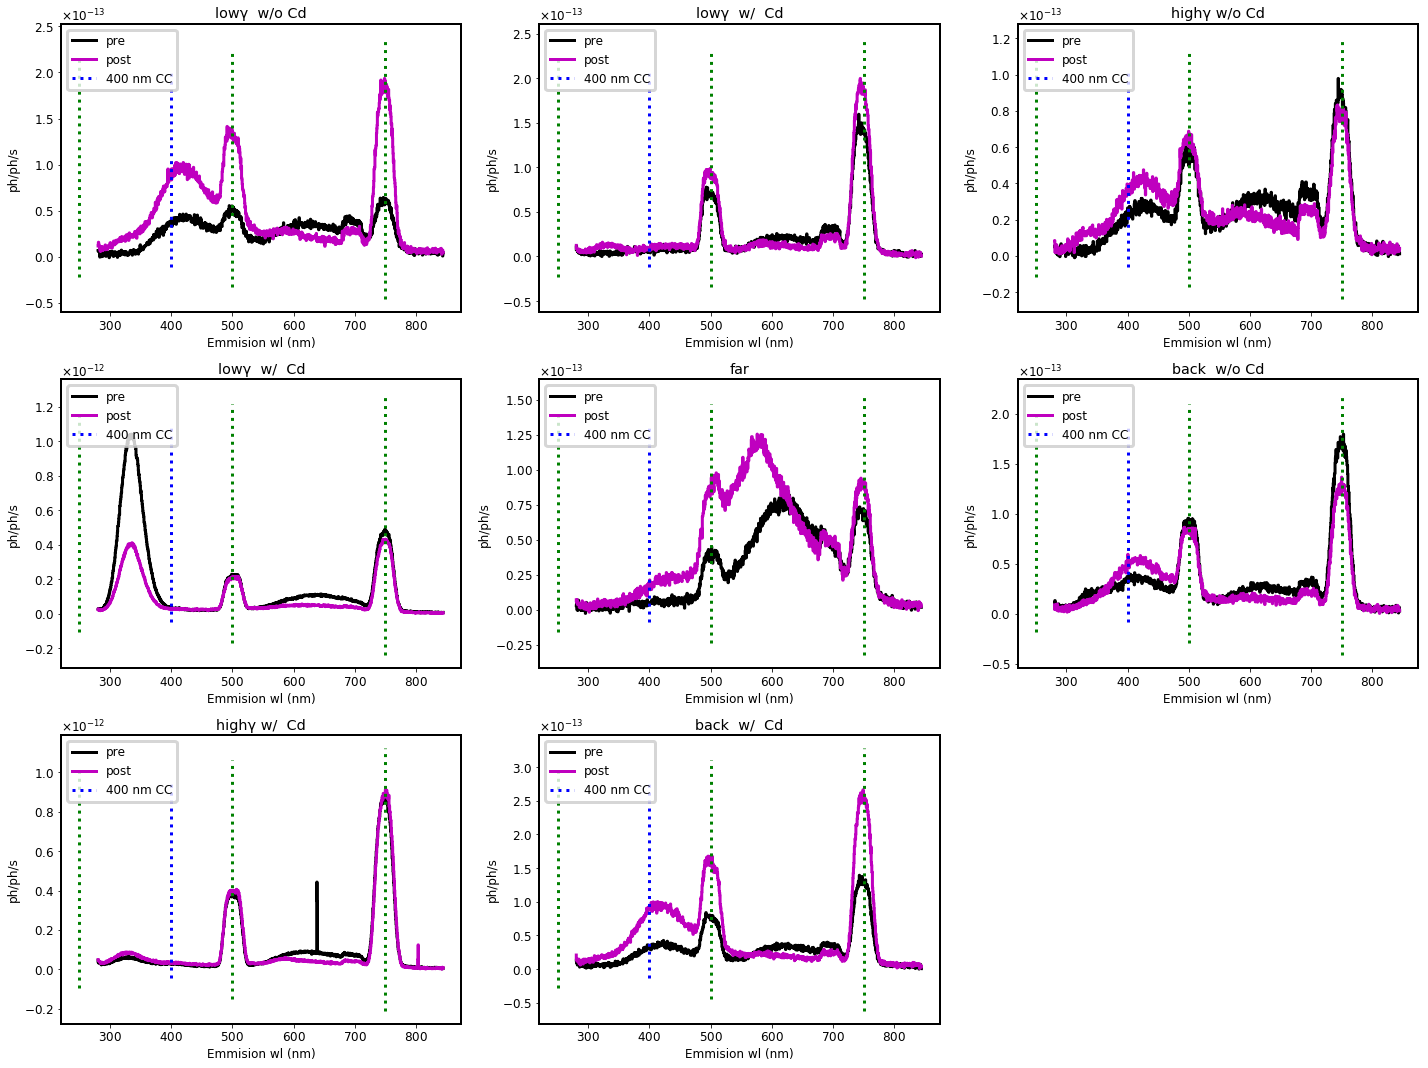

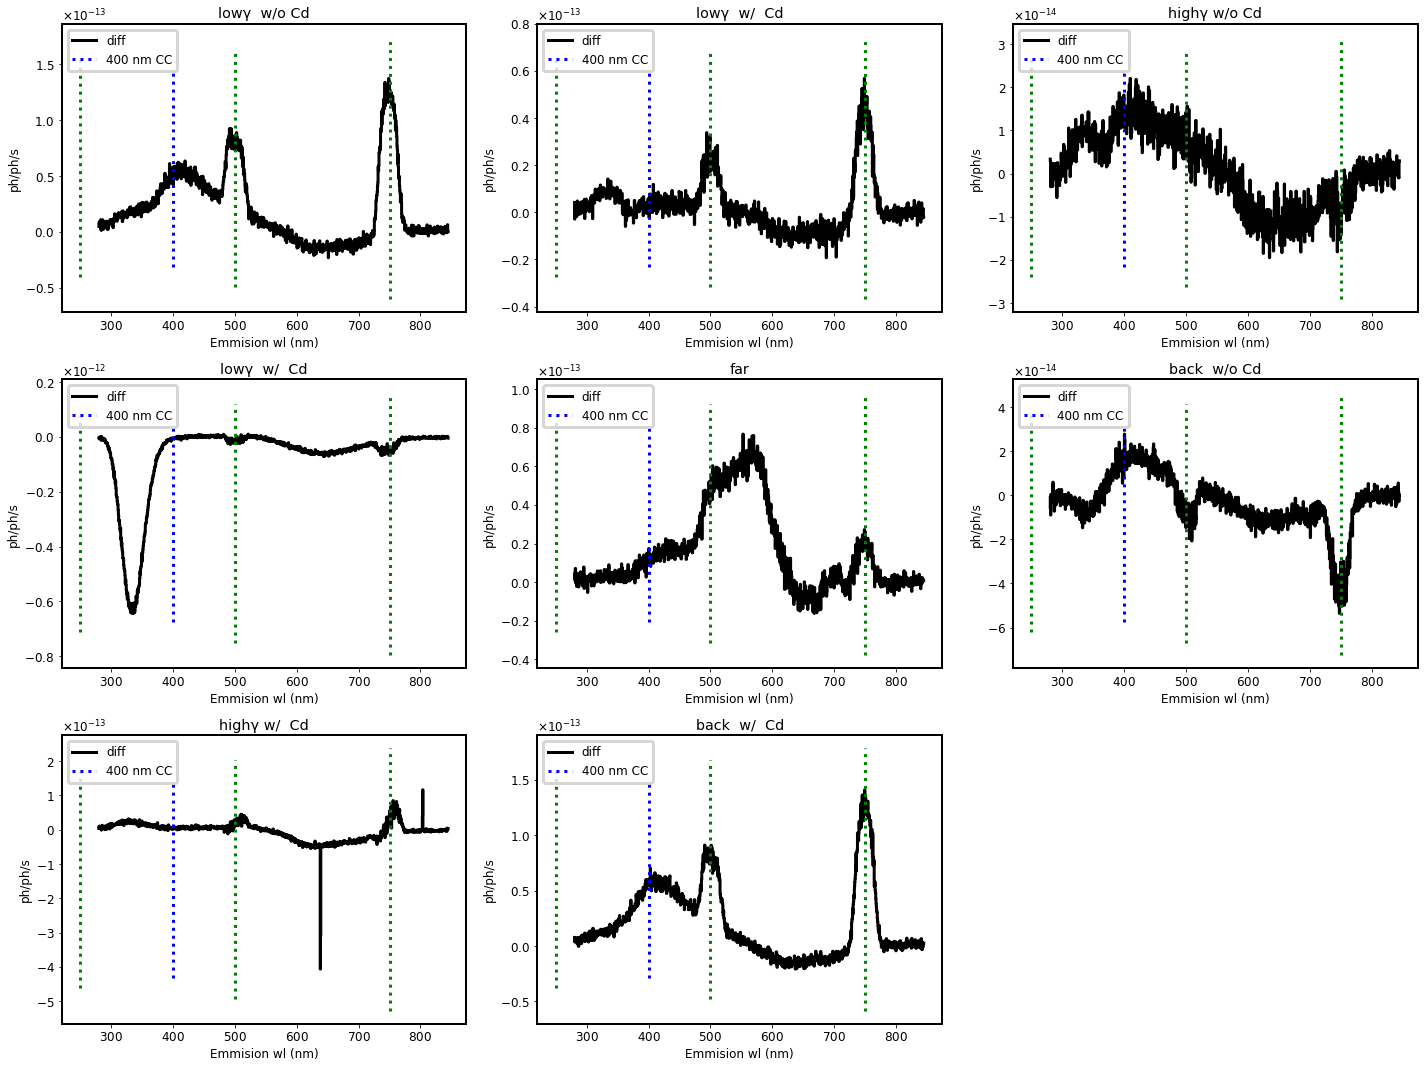

In [23]:
plot_prepost_diff(experiment, crystal_type, expected_signals=signals, legend_position="upper left", ex_wl=250, exposure=10)

# Quartz

In [9]:
crystal_type = "Qz"
signals      = paper_signals[crystal_type]

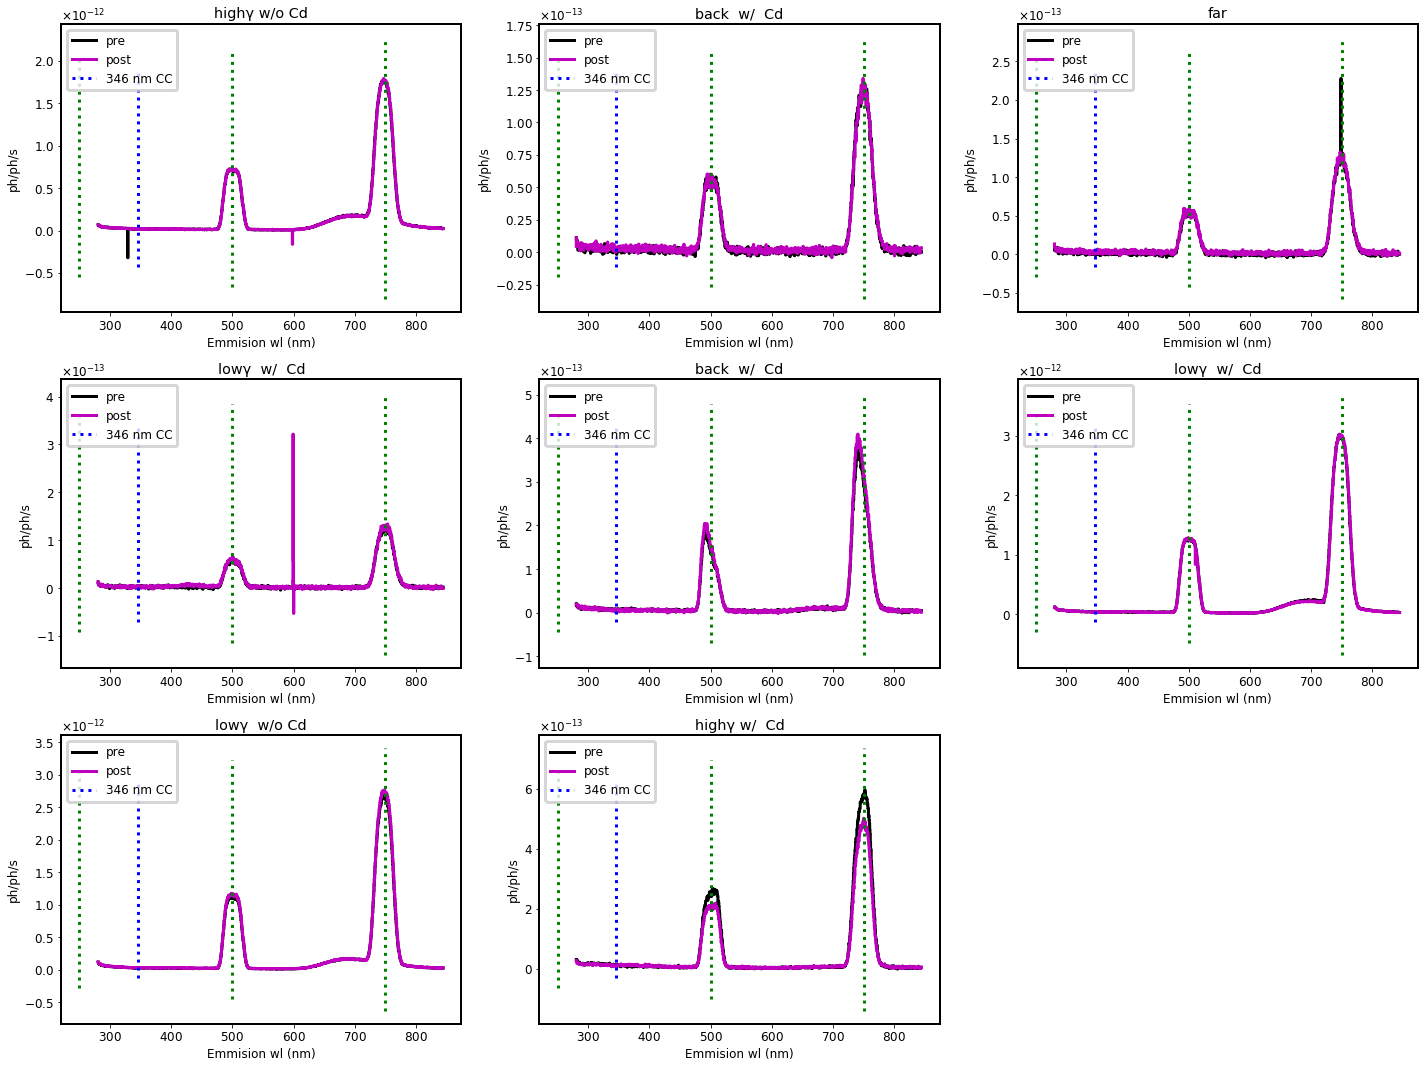

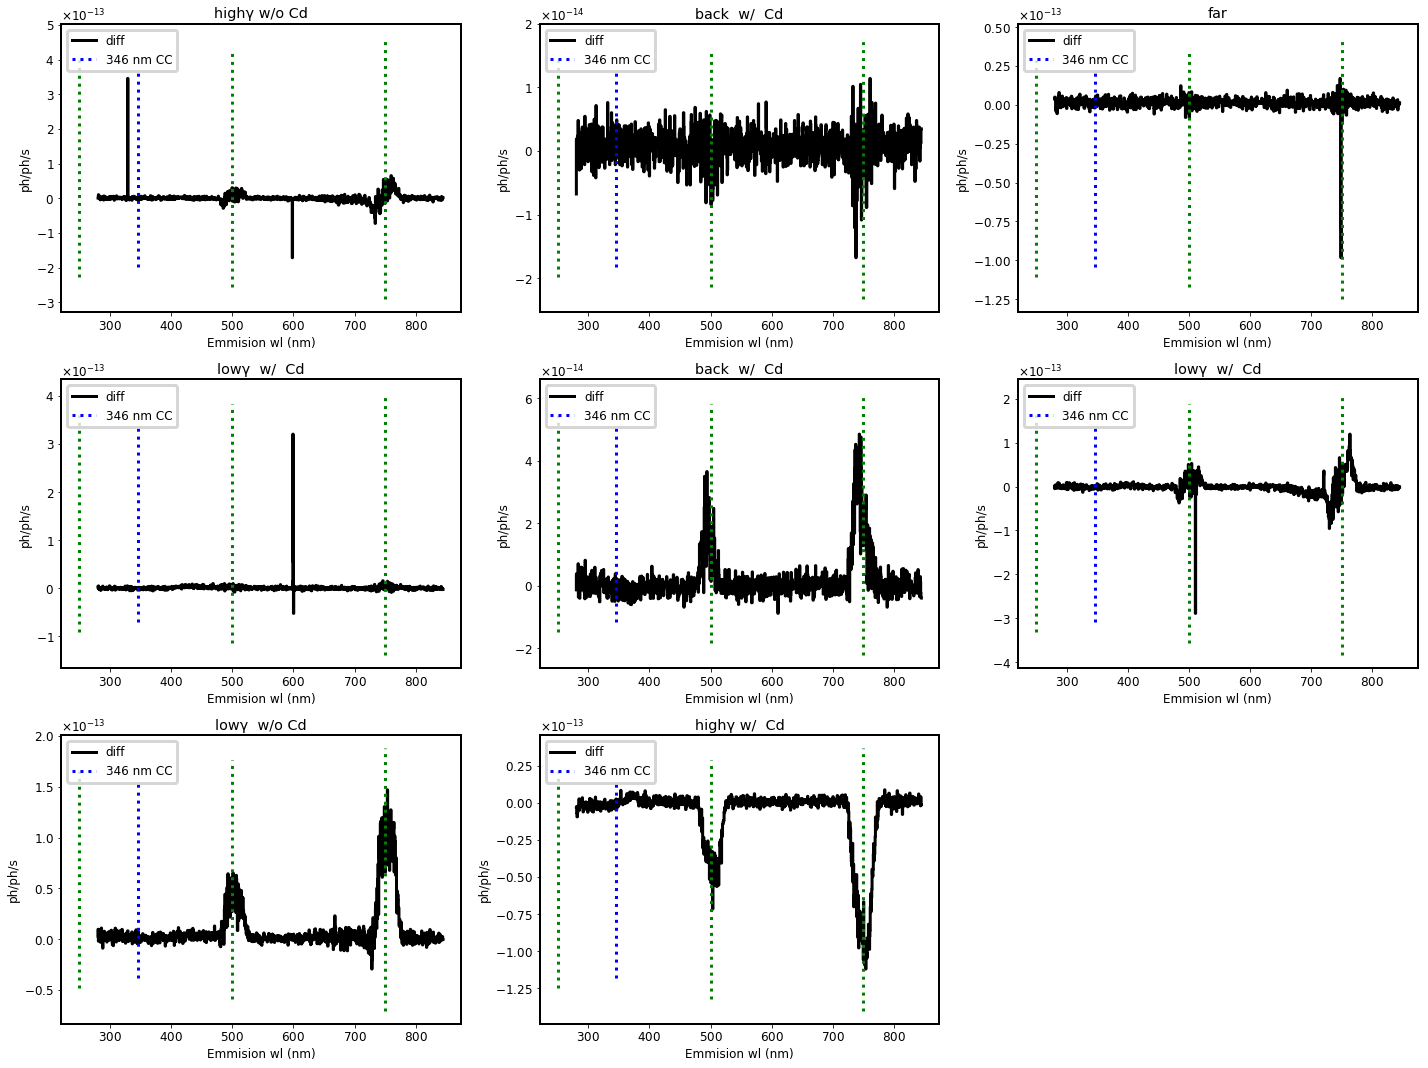

In [10]:
plot_prepost_diff(experiment, crystal_type=crystal_type, expected_signals=signals, legend_position="upper left", ex_wl=250, exposure=10)

# BaF

In [26]:
crystal_type = "BaF"
signals      = paper_signals[crystal_type]

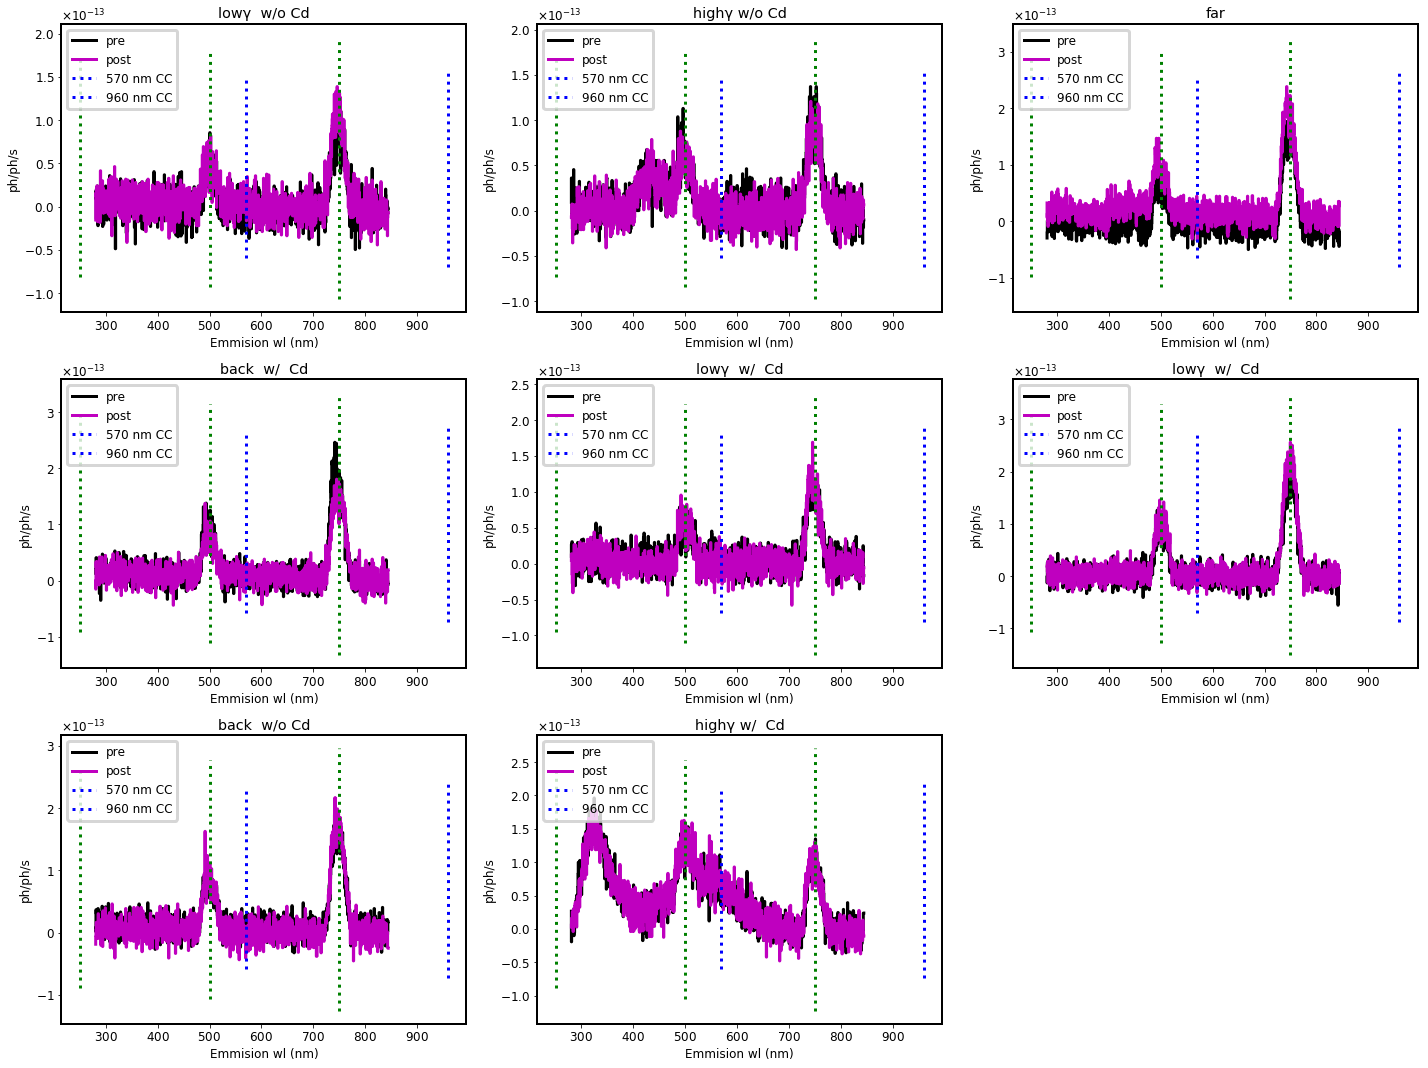

In [27]:
plot_prepost_diff(experiment, crystal_type=crystal_type, expected_signals=signals, legend_position="upper left", ex_wl=250, exposure=1)

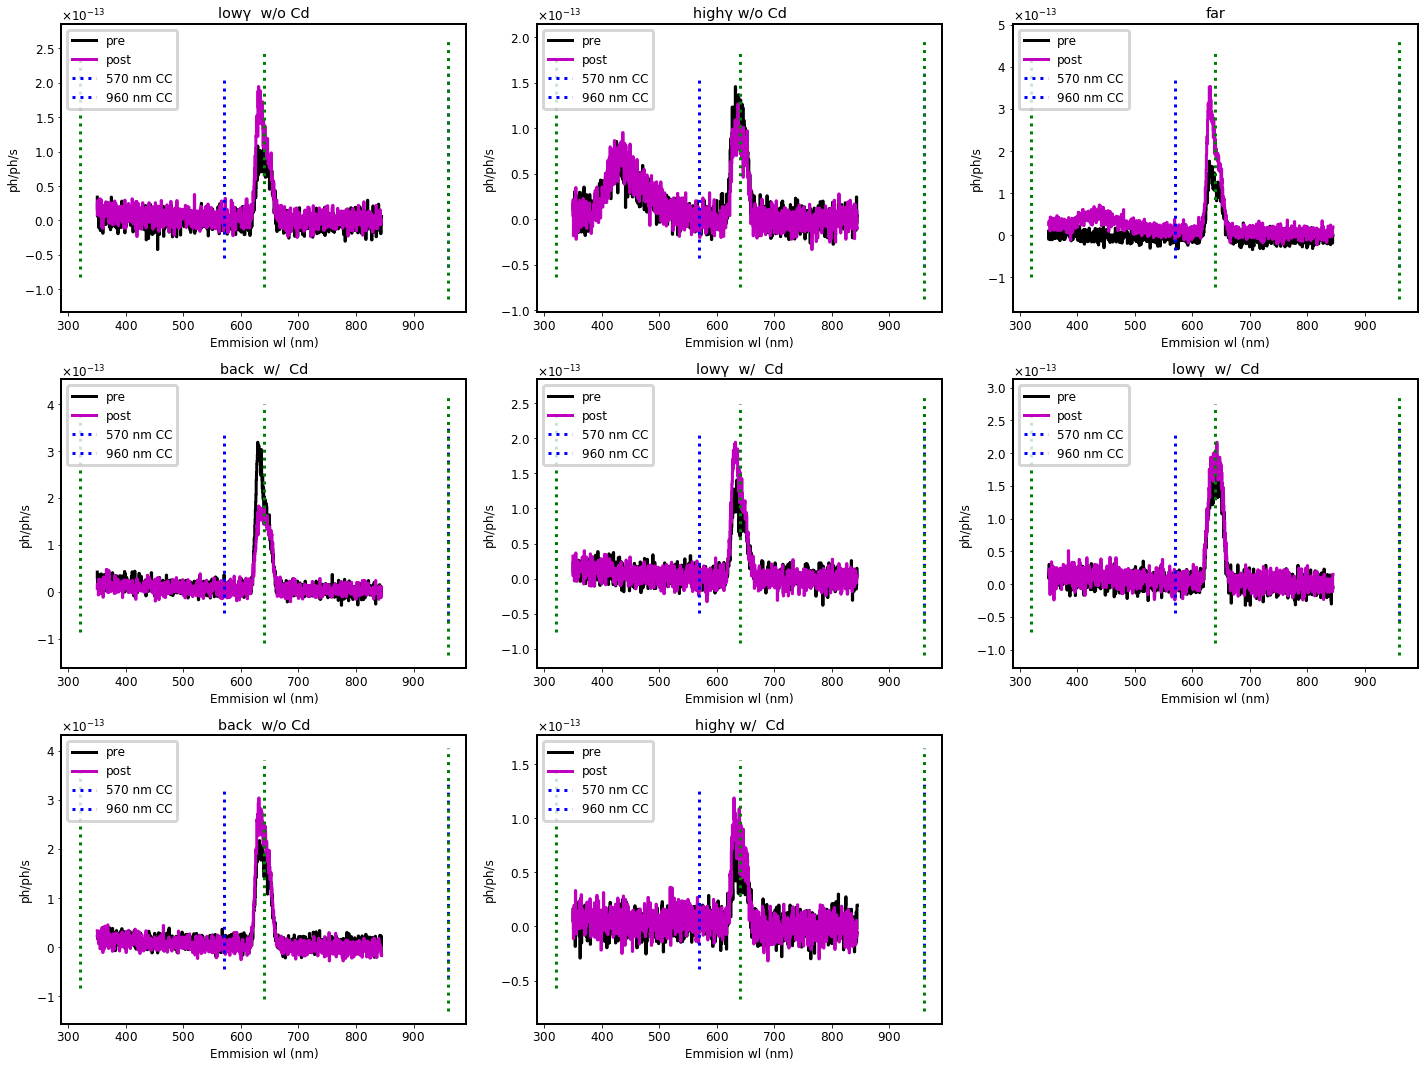

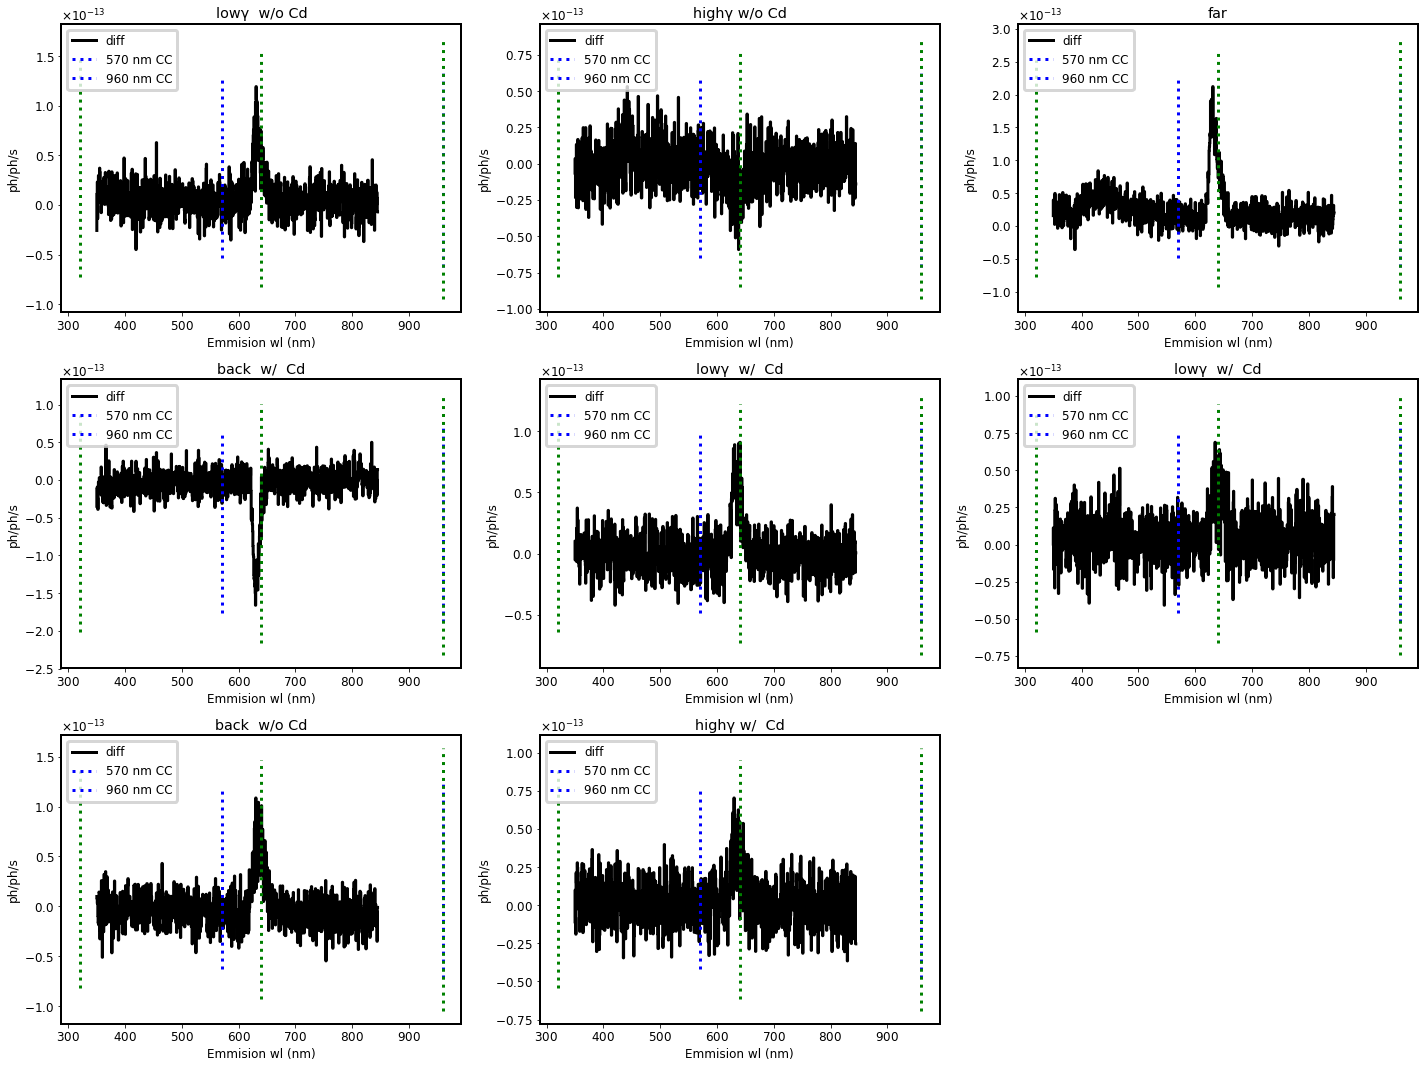

In [28]:
plot_prepost_diff(experiment, crystal_type=crystal_type, expected_signals=signals, legend_position="upper left", ex_wl=320, exposure=1)

# CaF

In [14]:
crystal_type = "CaF"
signals      = paper_signals[crystal_type]

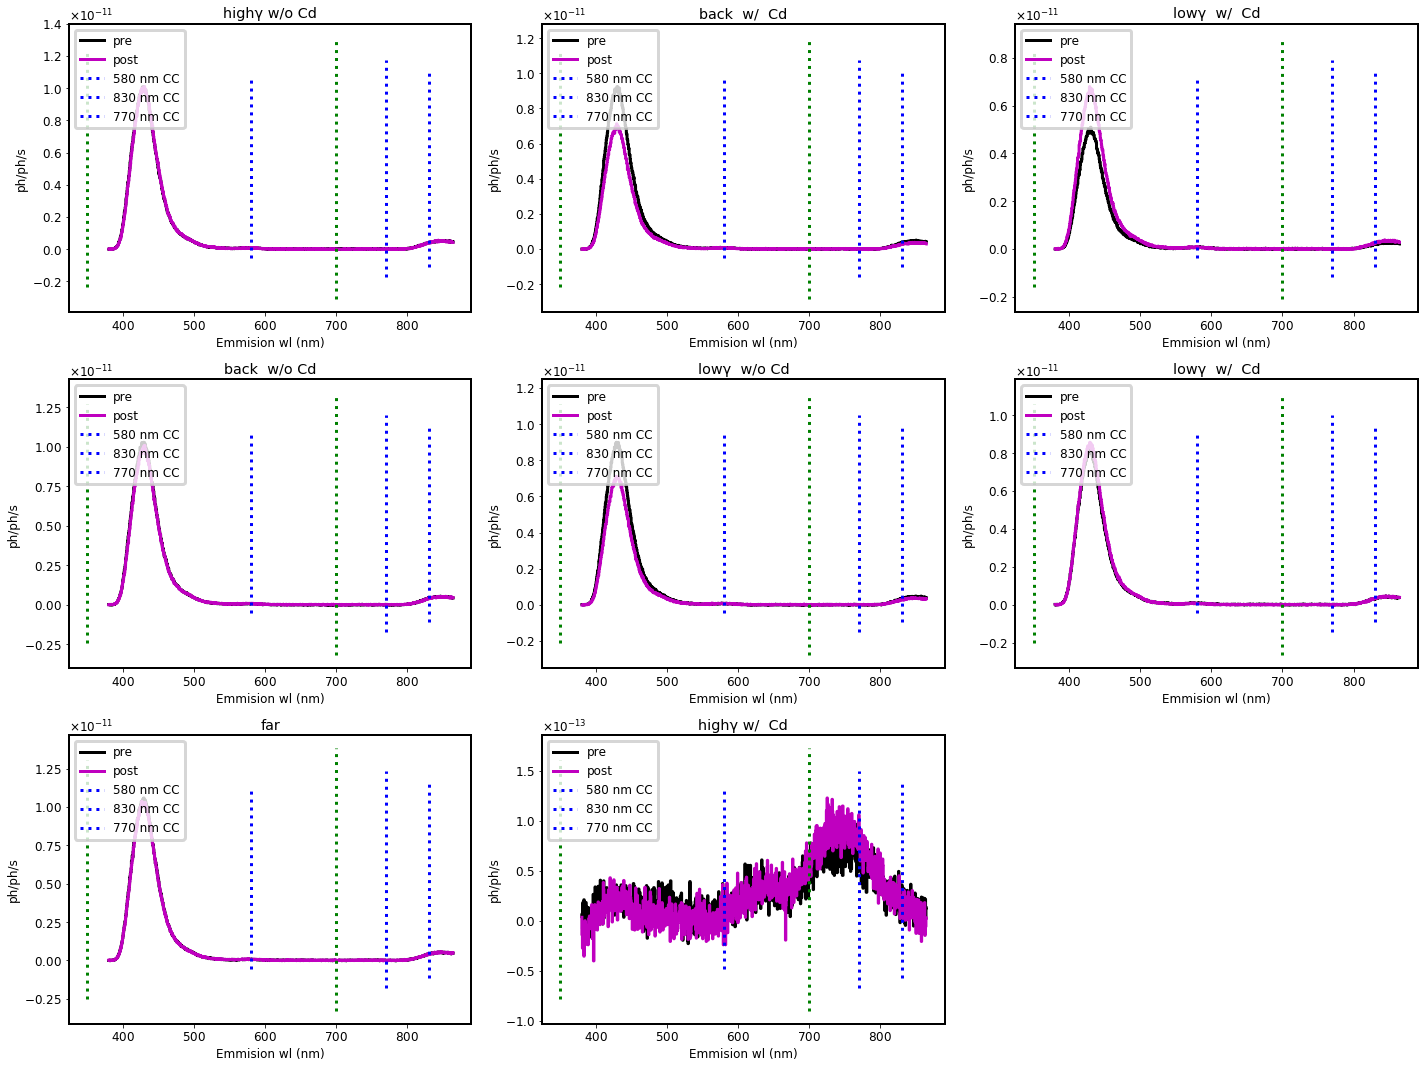

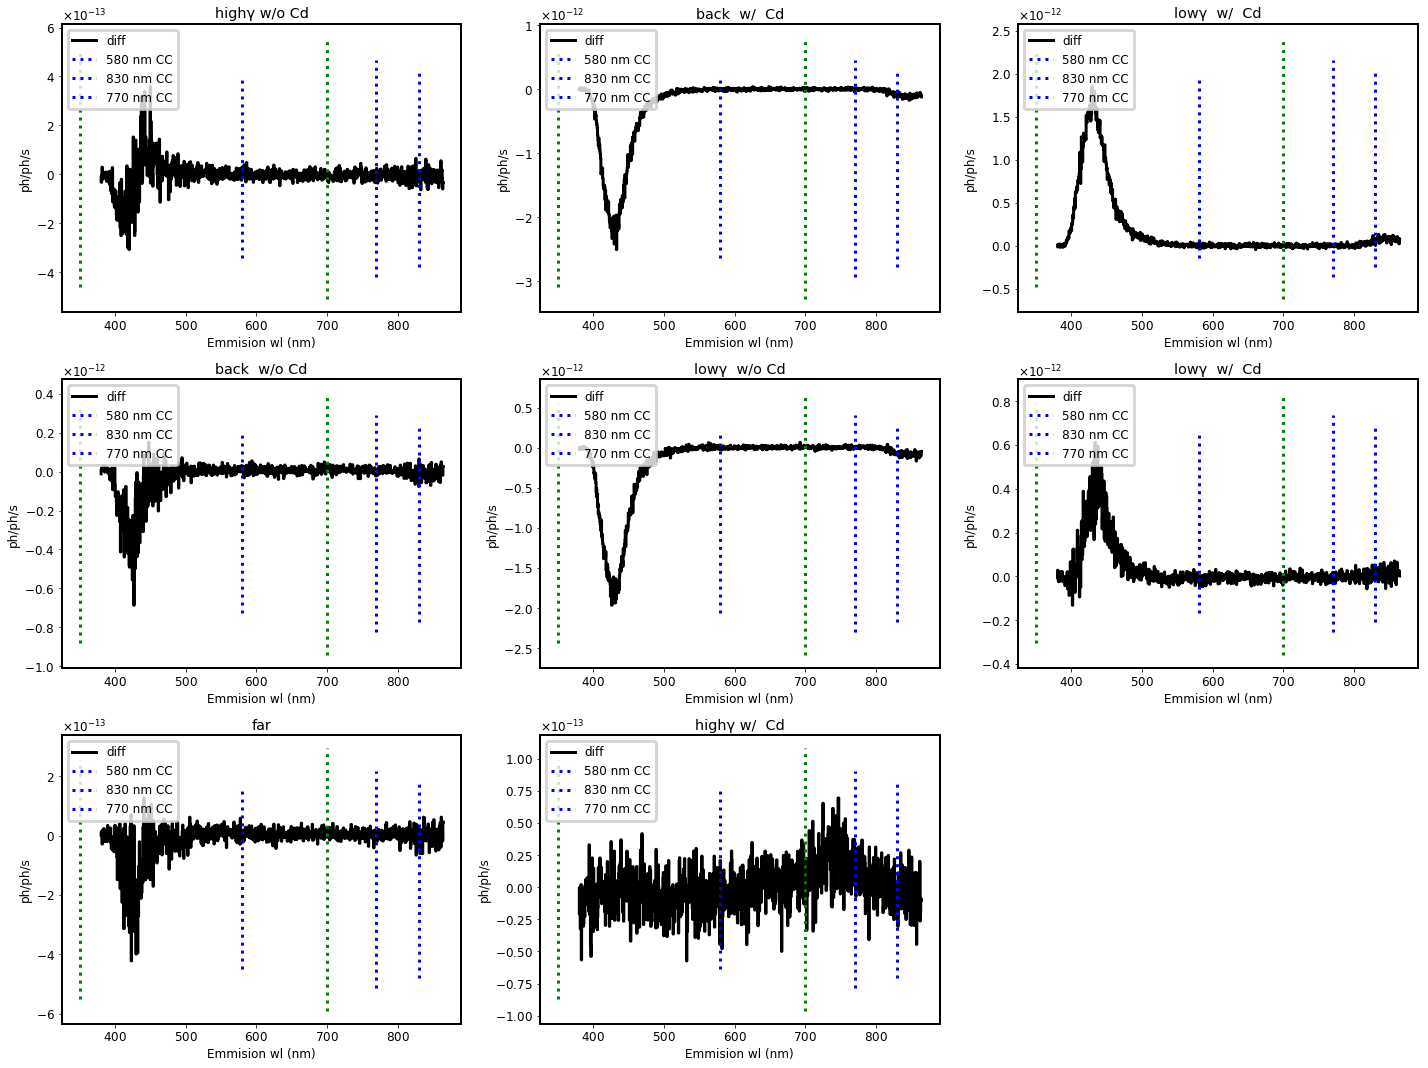

In [15]:
plot_prepost_diff(experiment, crystal_type=crystal_type, expected_signals=signals, legend_position="upper left", ex_wl=350, exposure=1)

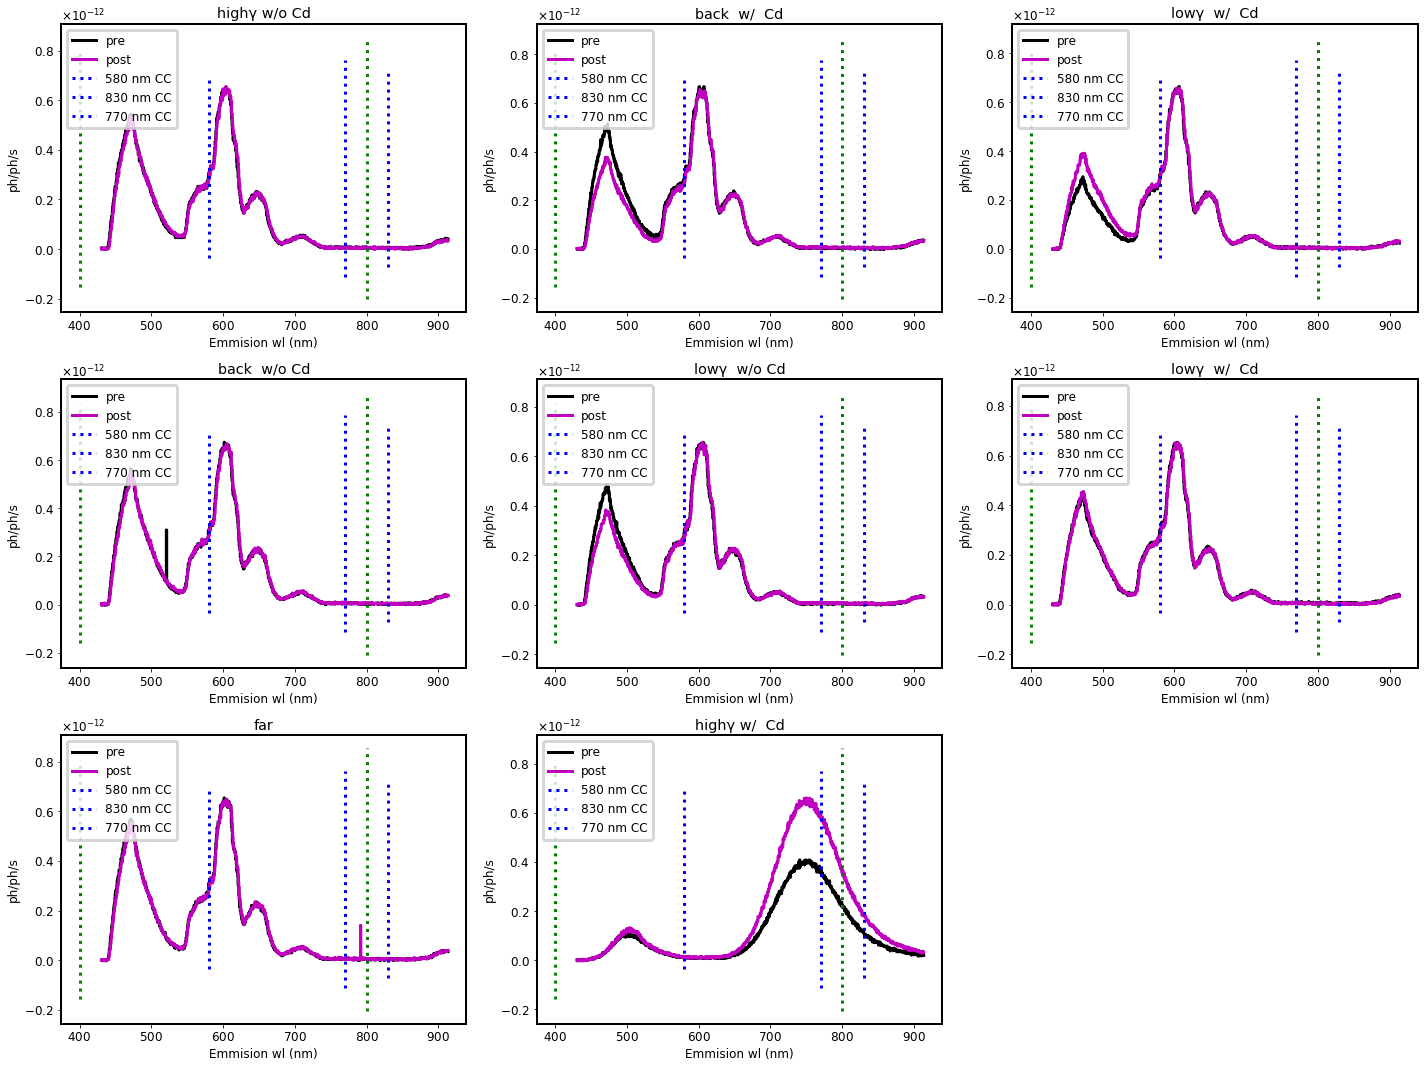

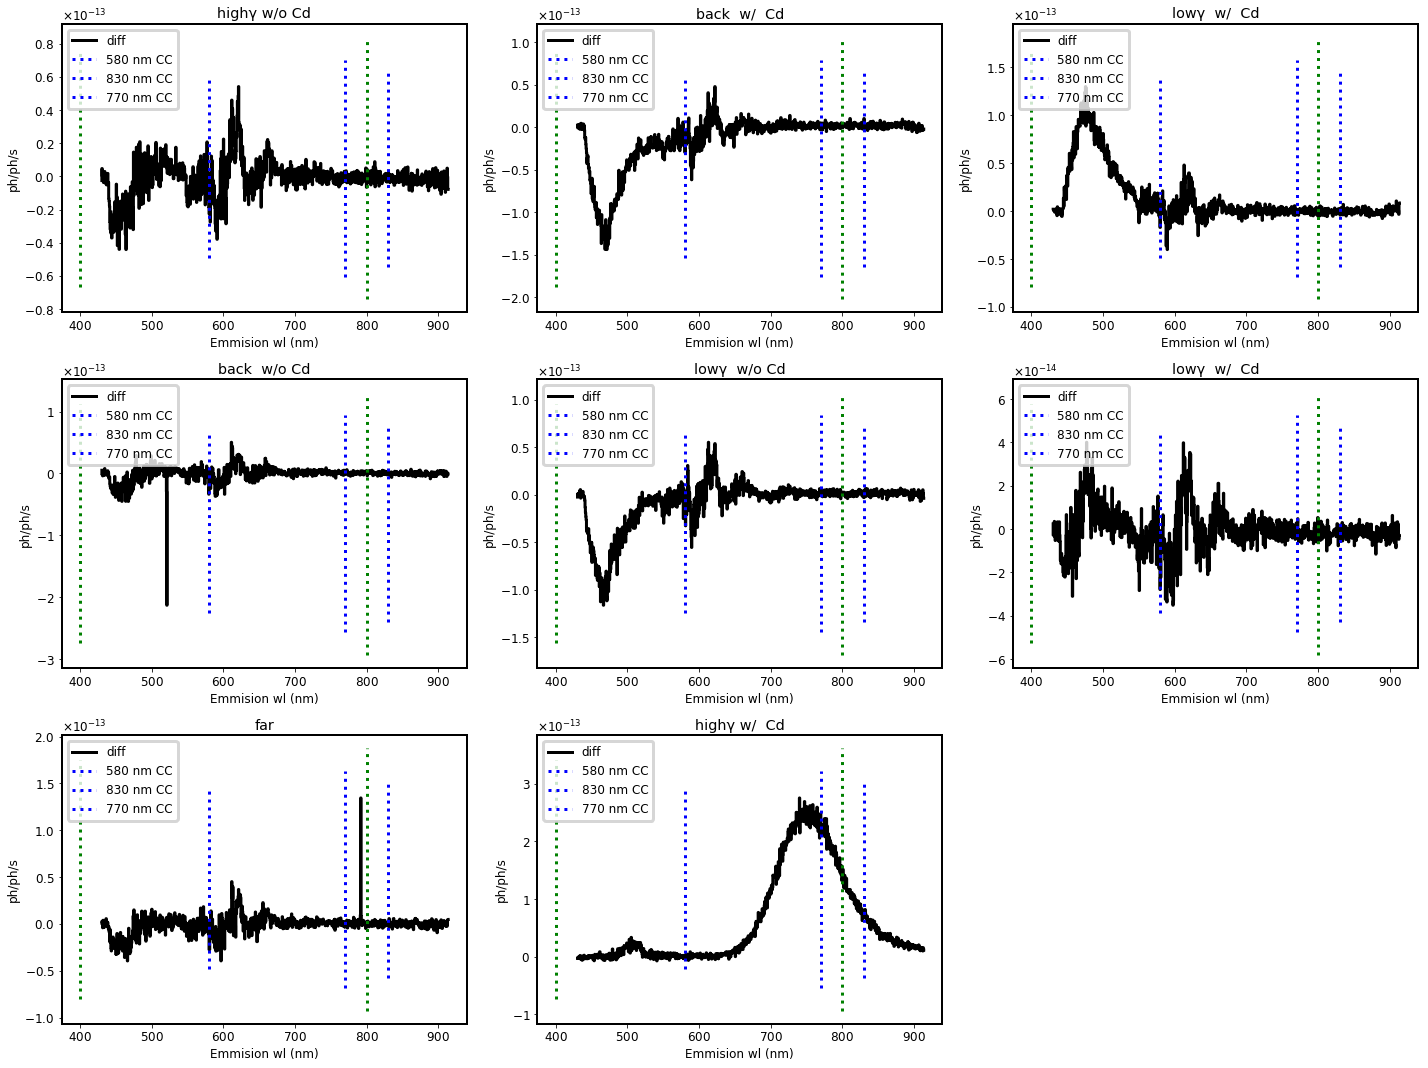

In [16]:
plot_prepost_diff(experiment, crystal_type=crystal_type, expected_signals=signals, legend_position="upper left", ex_wl=400, exposure=10)

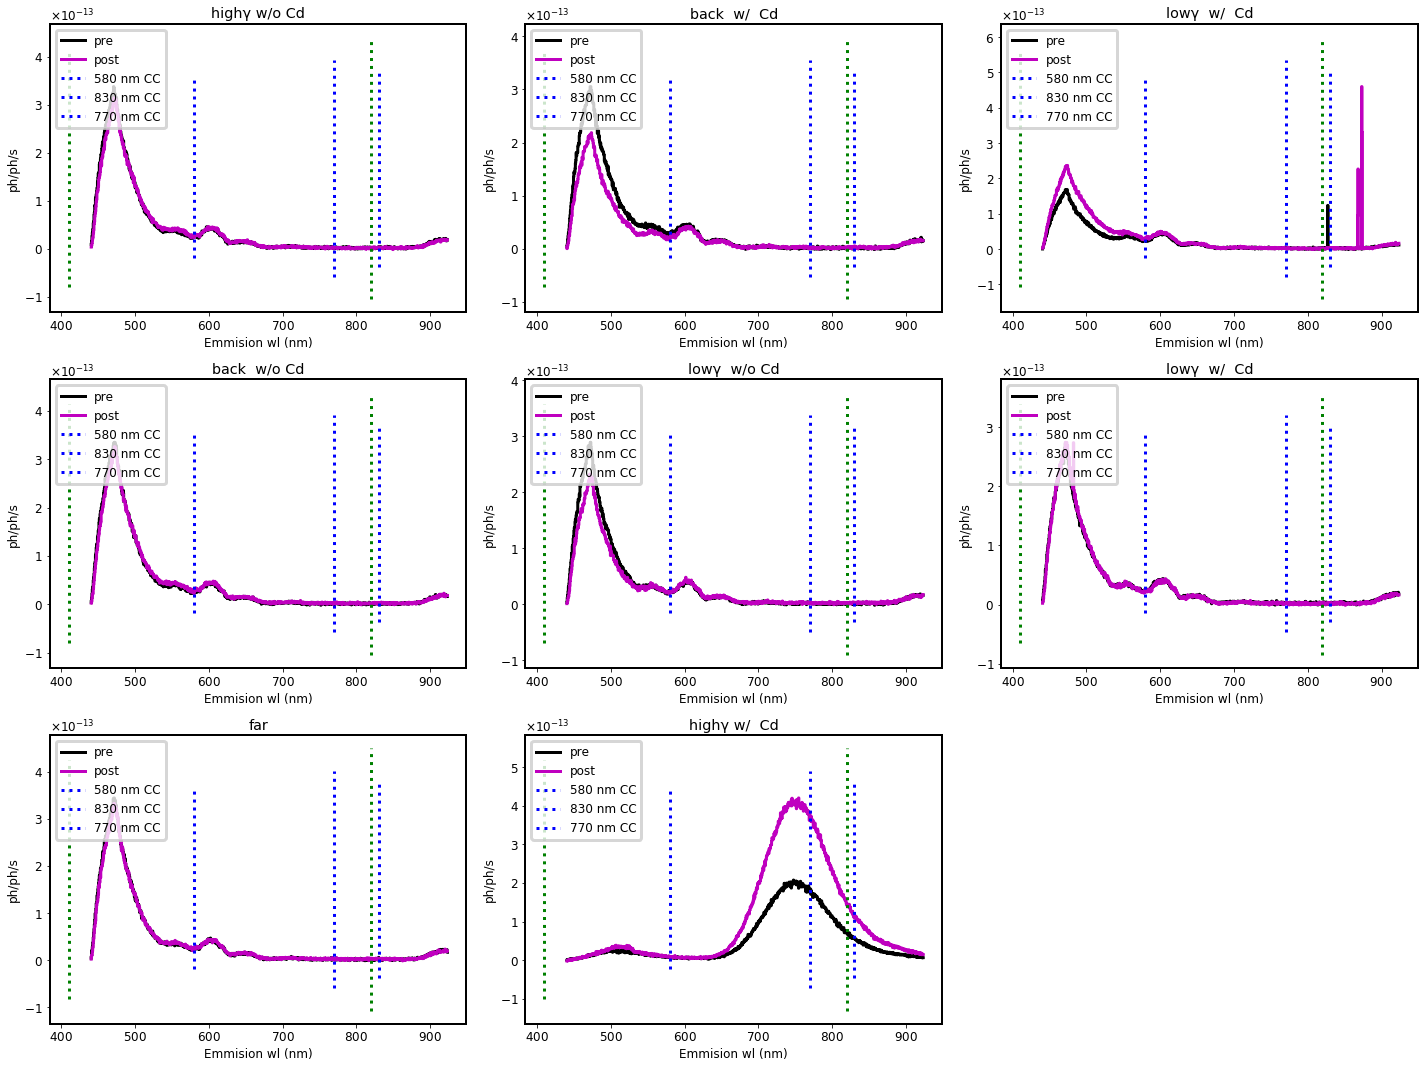

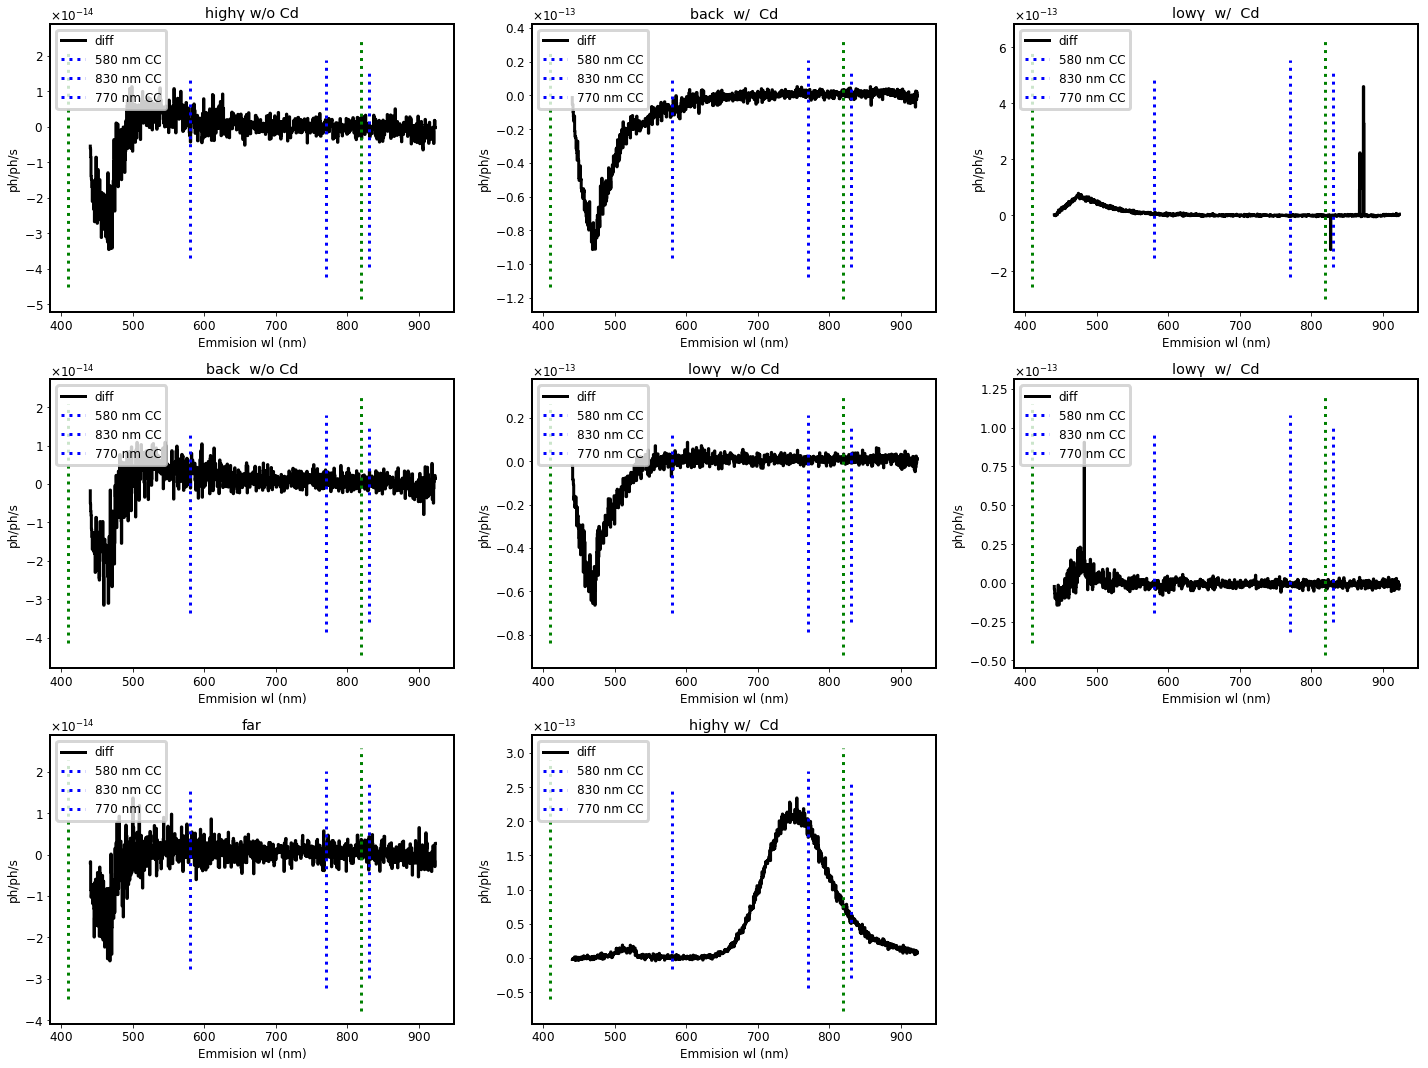

In [17]:
plot_prepost_diff(experiment, crystal_type=crystal_type, expected_signals=signals, legend_position="upper left", ex_wl=410, exposure=10)

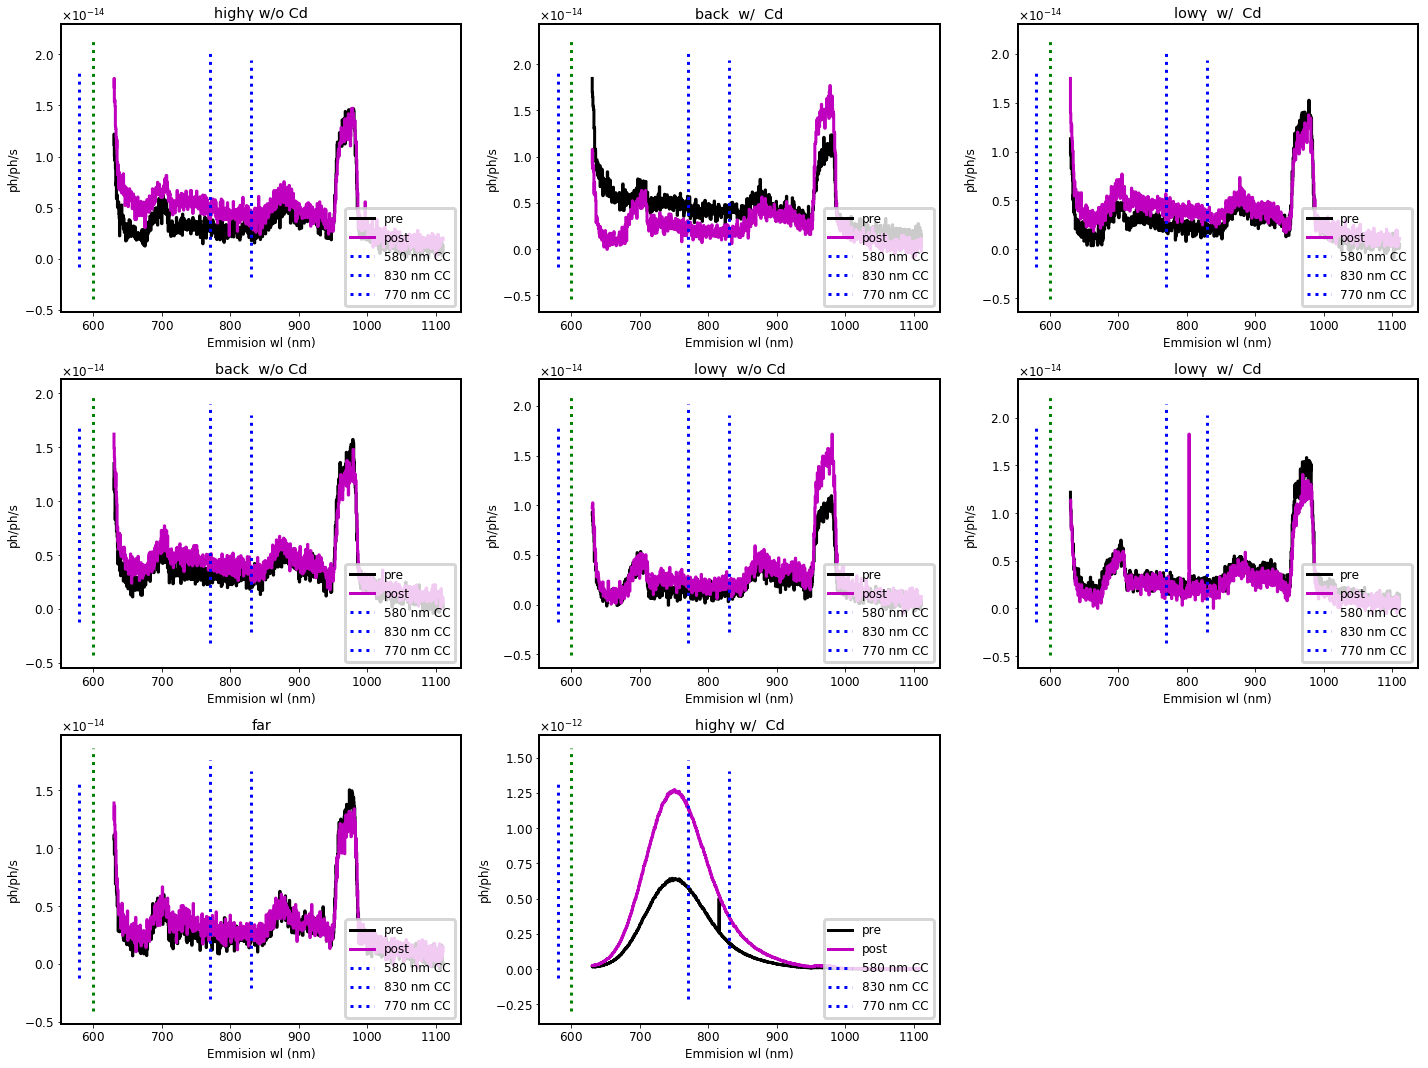

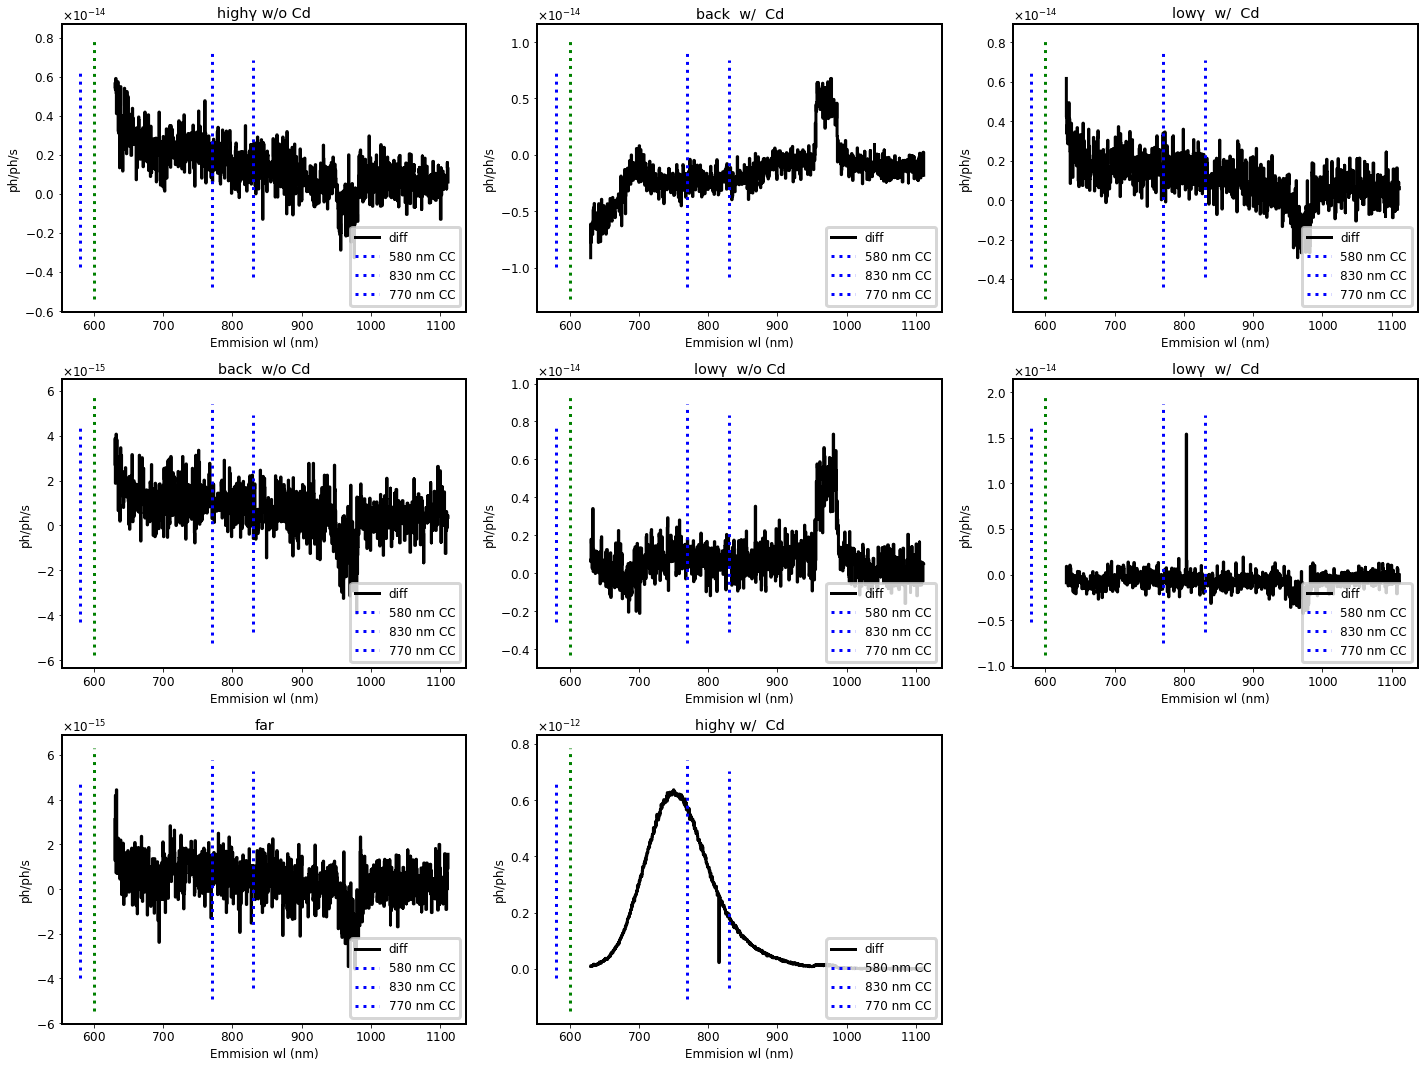

In [18]:
plot_prepost_diff(experiment, crystal_type=crystal_type, expected_signals=signals, legend_position="lower right", ex_wl=600, exposure=10)

# LiF

In [19]:
crystal_type = "LiF"
signals      = paper_signals[crystal_type]

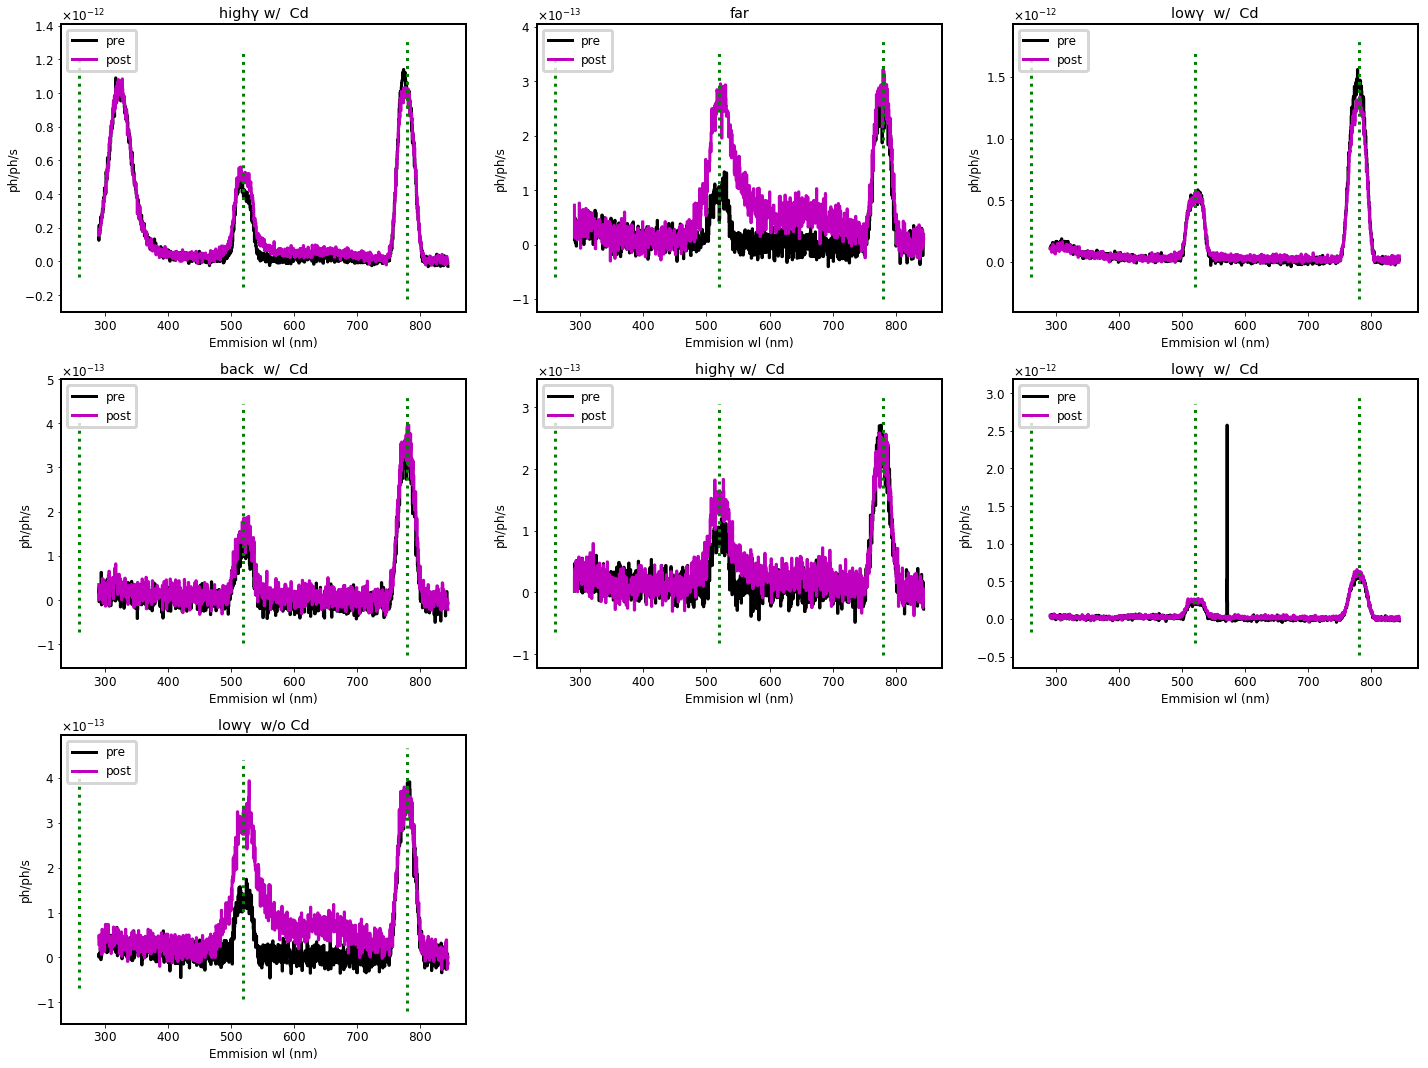

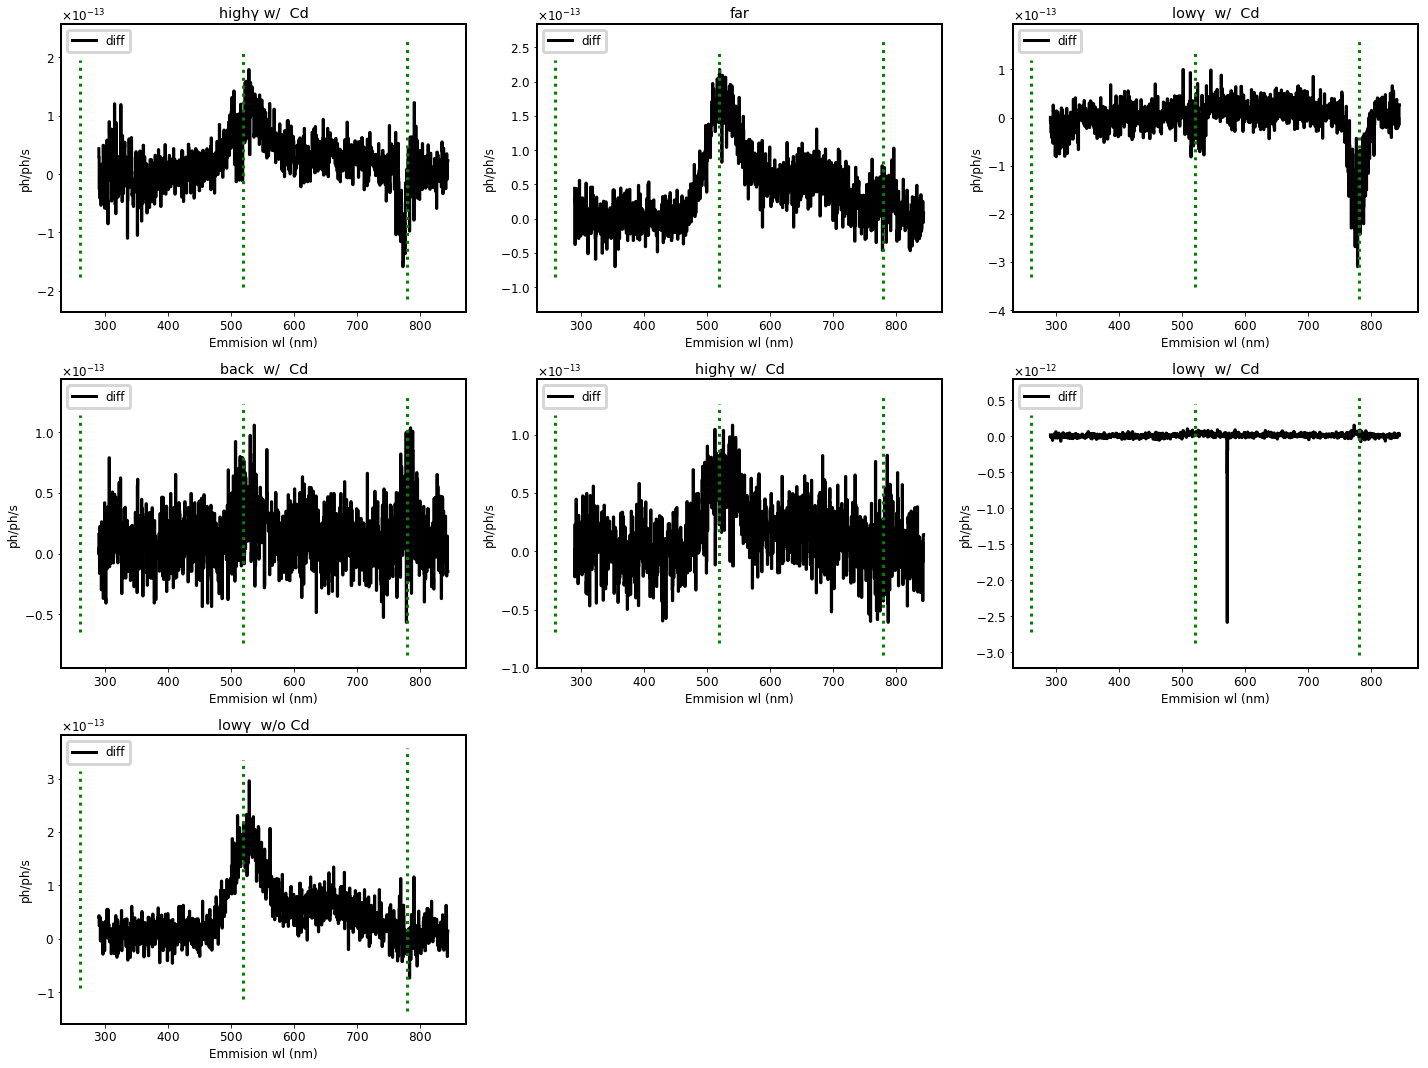

In [20]:
plot_prepost_diff(experiment, crystal_type=crystal_type, expected_signals=signals, legend_position="upper left", ex_wl=260, exposure=1)

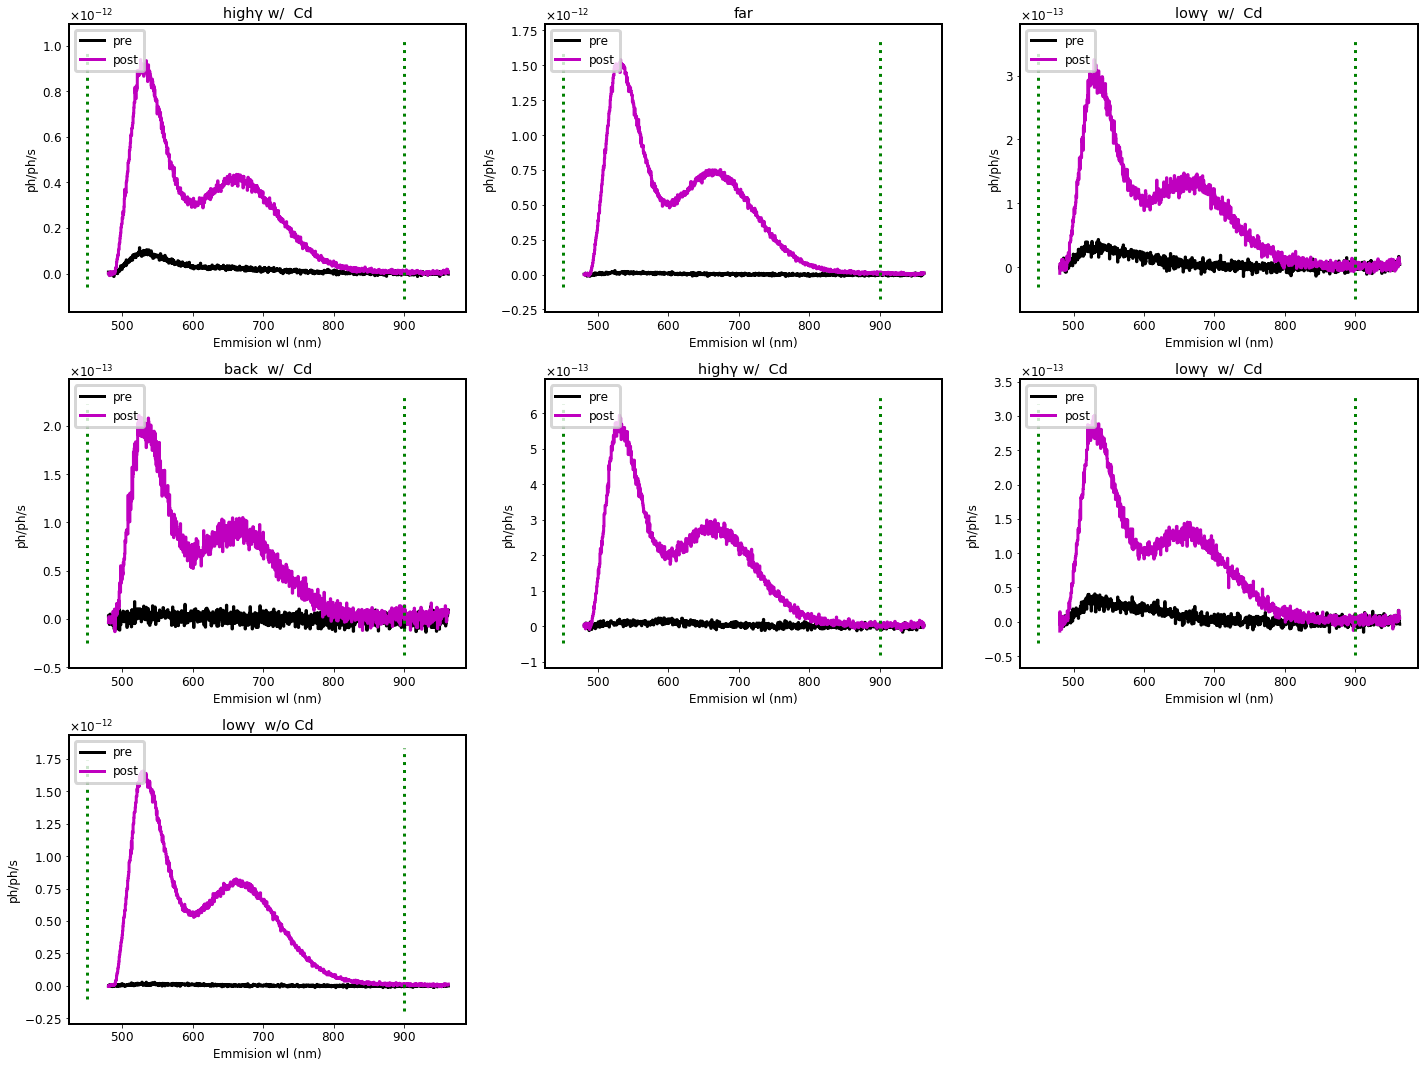

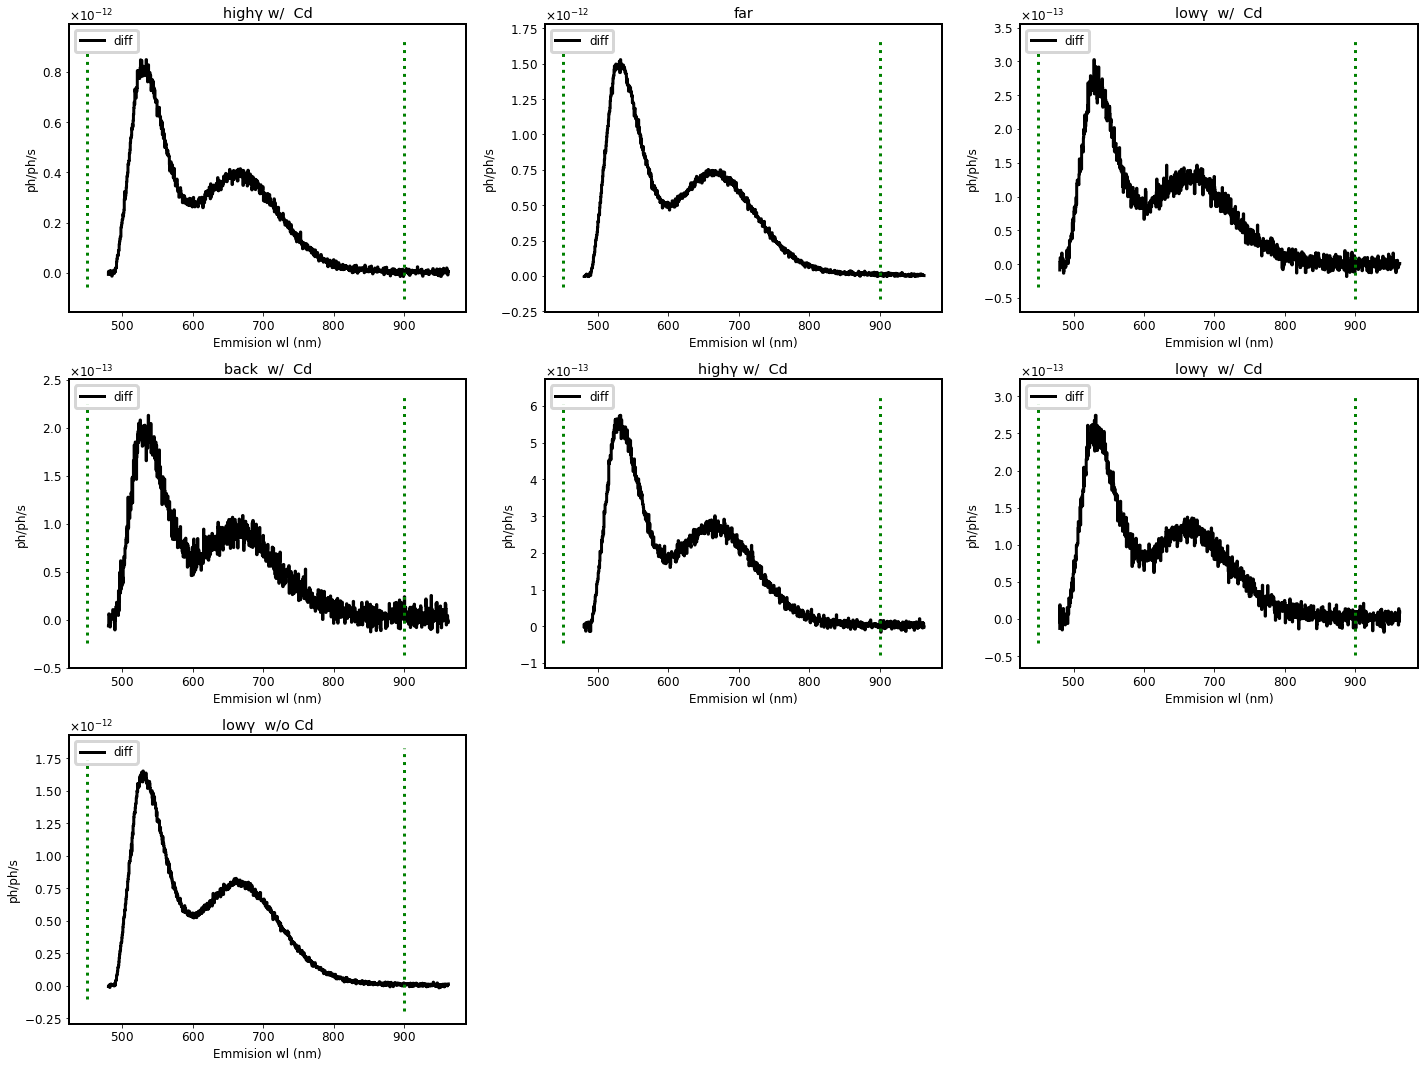

In [21]:
plot_prepost_diff(experiment, crystal_type=crystal_type, expected_signals=signals, legend_position="upper left", ex_wl=450, exposure=1)